In [1]:
import geopandas as gpd
#  import fiona
import leafmap.leafmap as leafmap 
import pandas as pd
import re
import os


# prep data

## switzerlanmd

In [71]:
# BERTopic100CharMin2500CharMax_10ClassesNewestData

#BERTopic100CharMin2500CharMax_20
# class_name_dict = {'no_class':-1,
#             '0_medical': 0, 
#             '1_social_service_asylum': 1,
#             '2_education': 2,
#             '3_banking': 3,
#             '4_nail_beauty': 4,
#             '5_passport_information': 5,
#             '6_advertisement': 6,
#             '7_transport_CHF_UK': 7,
#             '8_war_related_content': 8,
#             '9_train_CHF': 9,
#             '10_accomodation':10,
#             '11_accomodation':11,
#             '12_hair_beauty' : 12,
#             '13_train_and_bus_travel':13,
#             '14_transport_UKR_CH':14,
#             '15_S_Status':15,
#             '16_dental_services':16,
#             '17_vet_food' : 17,
#             '18_weblinks' : 18,
#             '19_accomodation':19
#             }
class_name_dict = {-1:"no_class",
    0:"Medical Information",
    1:"Asylum Information", 
    2:"Veterinarian",
    3:"Banking",
    4:"Passport Information",
    5:"Transportation UKR CHF", 
    (6,7):"Integration Problems", #ukr/rus identity
    7:"Integration Problems%", #chat rules
    8:"Education",
    9:"Accomodation",
    10:"Train and Bus Transport Europe",
    11:"Dentistry Information",
    12:"Social Services",#social services weblinks
    13:"S Status Application",
    14:"Quality Refugee Camp",
    15:"Asylum Information%",
    16:"Social Services Canton Specific",
    17:"Transportation UKR CHF", #passenger
    18:"Train Bus Transport in Switzerland",
    19:"Personal Care", #hair beauty etc.
    20:"Employment Opportunities",
    21:"Accomodation", #focus on families
    22:"Social Services%",#social services geneva
    23:"Social Services%",
    24:"Vaccination"
}

class_name_dict = {-1:"no_class",
    0:"Medical Information",
    **dict.fromkeys([1, 13, 15], "Asylum Information and “S Permit” Application"),
    2:"Veterinarian",
    3:"Banking",
    4:"Consulate Services",
    **dict.fromkeys([5, 17], "Transportation between Ukraine and Switzerland"),
    **dict.fromkeys([6, 7], "Integration Problems"),
    8:"Education",
    9:"Accomodation",
    10:"Train and Bus Transport in Europe",
    11:"Dentistry Information",
    **dict.fromkeys([12, 16, 22, 23], "Social Services"),
    14:"Quality Refugee Camp",
    18:"Train Bus Transport in Switzerland",
    19:"Personal Care",
    20:"Employment Opportunities",
    21:"Accomodation", 
    24:"Vaccination"
}

canton_chat_dict = {'https://t.me/helpfulinfoforua': 'general',
 'https://t.me/ukraine_reborn': 'general',
 'https://t.me/BeautySwitzerland': 'general',
 'https://t.me/help_people_fromUkraine': 'general',
 'https://t.me/LousanneUkraine': 'Vaud',
 'https://t.me/LuzernUkraine': 'Lucerne',
 'https://t.me/ValaisUkraine': 'Valais',
 'https://t.me/ThurgauUkraine': 'Thurgau',
 'https://t.me/BielBienneUkraine': 'Bern',
 'https://t.me/fribourg1': 'Fribourg',
 'https://t.me/campax_ukraine_help_switzerland': 'general',
 'https://t.me/refugeesinSwitzerland': 'general',
 'https://t.me/zh_helps_ukraine': 'Zürich',
 'https://t.me/zh_helps_UArefugee': 'Zürich',
 'https://t.me/zurich_hb_help': 'Zürich',
 'https://t.me/zh_housing': 'Zürich',
 'https://t.me/helppetsfromukraine': 'general',
 'https://t.me/Zurich_UA': 'Zürich',
 'https://t.me/zh_helps_UArefugees': 'Zürich',
 'https://t.me/seep_helpukrainians': 'general',
 'https://t.me/Zh_helps_UA_mums': 'Zürich',
 'https://t.me/job_sw_ukrainians': 'general',
 'https://t.me/zh_back_ukraine': 'Zürich',
 'https://t.me/zh_helps_logistics': 'Zürich',
 'https://t.me/AargauUkraine': 'Aargau',
 'https://t.me/BernUkraine': 'Bern',
 'https://t.me/TicinoLuganoUkraine': 'Ticino',
 'https://t.me/UASchweiz': 'general',
 'https://t.me/SwissUA': 'general',
 'https://t.me/BaselUkraine': 'Basel',
 'https://t.me/ukrainer_basel': 'Basel',
 'https://t.me/GeneveUkraine': 'Genève',
 'https://t.me/StGallenUkraine': 'Sankt Gallen'}

import json 

f = open('../DGO/cities_in_canton/cities_in_canton.json')
  
# returns JSON object as 
# a dictionary
ciy_canton_dict = json.load(f)


In [68]:
test = "**Сайт Цюрихского университета, Центр стоматологической медицины**: ""У вас нет личного стоматолога? Мы будем рады уточнить у вас по телефону, считаются ли ваши жалобы неотложными. Пожалуйста, позвоните нам перед визитом: Номер телефона: 044 634 33 11 В ночное время (с 5:00 вечера до 8:00 утра), а также в выходные и праздничные дни: Пожалуйста, свяжитесь со службой неотложной помощи кантона Цюрих по телефону номер телефона 0800 33 66 55"". Website of the University Zürich, Zentrum für Zahnmedizin: ""You don’t have a personal dentist? We will be glad to clarify with you on the phone whether your complaints are considered to be an emergency. Please call us before your visit: Phone number: 044 634 33 11 At night (5:00 p.m. to 8:00 a.m.) and on weekends and public holidays: Please contact the emergency service of the Canton of Zurich on phone number 0800 33 66 55."

In [88]:
def check_key_in_string(string, dictionary):
    for key in dictionary:
        if key in string:
            return dictionary[key]
    return "general"

In [89]:
check_key_in_string(test, ciy_canton_dict)

'Zürich'

## Europe

In [52]:
class_name_dict = {'no_class':-1,
            'Medical Care': 0, 
            'Accomodation': 1,
            'Transport to and from Ukraine': 2,
            'Animal Welfare': 3,
            'Banking': 4,
            'Government Services and Asylum%%': 5,
            'Government Services and Asylum%': 6,
            'Public Transport within Europe': 7,
            'Government Services and Asylum': 8,
            'COVID-19 Vaccination': 9}
class_name_dict = {y: x for x, y in class_name_dict.items()}
country_chat_dict ={
            "Austria":"https://t.me/refugeesinAustria",
            "Belgium":"https://t.me/refugeesinBelgium",
            "Cyprus":"https://t.me/uacyprus",
            "Czech Republic":"https://t.me/dopomoga_cz",
            "Denmark":"https://t.me/Denmark_Ukraine",
            "France":"https://t.me/refugeesinFrance",
            "Germany":"https://t.me/refugees_in_Germany",
            "Greece":"https://t.me/help_ukranian_in_greece_chat",
            "Hungary":"https://t.me/helpukraine_hungary",
            "Ireland":"https://t.me/WelcomeIreland",
            "Italy":"https://t.me/Ukrainians_Italy",
            "Latvia":"https://t.me/ukrainelatvia",
            "Luxembourg":"https://t.me/helpforUkrainians_Luxemburg",
            "Netherlands":"https://t.me/dopomoganetherlands",
            "Poland":"https://t.me/refugeesinPoland",
            "Portugal":"https://t.me/toportugal",
            "Romania":"https://t.me/UkrainiansinRomania",
            "Slovakia":"https://t.me/ukrajinci_na_slovensku",
            "Spain":"https://t.me/espana_ucrania",
            "Sweden":"https://t.me/refugeesinSweden",
            "Switzerland":"https://t.me/refugeesinSwitzerland",
            "United Kingdom":"https://t.me/UA_England",
            "Moldova":"https://t.me/moldovaukraina"
            }
country_chat_dict = {y: x for x, y in country_chat_dict.items()}

# Prepare for App

In [100]:
# df = pd.read_csv("../models/BERTopic100CharMin2500CharMax_25/df_sentimet.csv")
df = pd.read_csv("../models/BERTopic100CharMin2500CharMax_25Classes_dropDuplicates/df_prepfinal.csv")


In [3]:
df = gpd.read_file("../data/geodata/geojson/europe.geojson")

In [9]:
df_model = pd.read_csv("../models/BERTopic/news_k25/df_model.csv")
df_date = pd.read_csv("../models/BERTopic/news_k25/googleNews.csv")

In [22]:
df_telegram = pd.read_csv("../models/BERTopic/telegram_k25/df_model.csv")

In [27]:
df_telegram = df_telegram[df_telegram.cluster!= -1]

In [32]:
df_twitter

,query,id,text,edit_history_tweet_ids,created_at,cluster
0,Austria,1621554449251549184,RT @tanjamaier17: A man just wrote me from Kyi...,['1621554449251549184'],2023-02-03T17:01:22.000Z,-1.0
1,Austria,1621510075717398529,🇦🇹🇺🇦 Zelensky imposed new sanctions against Au...,['1621510075717398529'],2023-02-03T14:05:02.000Z,-1.0
2,Austria,1621489878847332353,@MuscalR @StarskyUA I am in Austria and this c...,['1621489878847332353'],2023-02-03T12:44:47.000Z,24.0
3,Austria,1621481782062325762,(15) Falschinfos rund um ukrainische Geflüchte...,['1621481782062325762'],2023-02-03T12:12:37.000Z,-1.0
4,Austria,1621427724098174978,A man just wrote me from Kyiv. His wife lived ...,['1621427724098174978'],2023-02-03T08:37:48.000Z,-1.0
...,...,...,...,...,...,...
500566,Ukraine,1494238619388817409,@nypost #UkraineConflict #StandWithUkraine #H...,['1494238619388817409'],2022-02-17T09:13:43.000Z,19.0
500567,Ukraine,1494238157000351746,@DoreeLewak @nypost #UkraineConflict #StandWi...,['1494238157000351746'],2022-02-17T09:11:52.000Z,2.0
500568,Ukraine,1492609691481952261,"Yes, war is a terrible thing. I hope there's n...",['1492609691481952261'],2022-02-12T21:20:56.000Z,23.0
500569,Ukraine,1490266517463658496,Economic side of the war: In case of Russian i...,['1490266517463658496'],2022-02-06T10:10:00.000Z,-1.0


In [33]:
df_twitter.cluster.unique()

array([-1., 24.,  1.,  0.,  4., 15., 17., 19.,  2., 23., 10.,  3., 11.,
       14., 12.,  5., 13., 20.,  9.,  6., 16., 21.,  8., 18.,  7., 22.,
       nan])

In [98]:
df['region'] = df['chat'].apply(lambda x: canton_chat_dict[x])

In [95]:
df['region'] = df['messageText'].apply(lambda x: check_key_in_string(x, ciy_canton_dict))

In [90]:
path = "../models/BERTopic100CharMin2500CharMax_25Classes_dropDuplicates/df.csv"

def count_reaction(reaction):
    if isinstance(reaction, str):
        m = re.findall('count=(.+?),', reaction)
        m = [int(x) for x in m]
        return sum(m)
    else:
        return float(0)

def prep_data(path, class_name_dict,canton_chat_dict,ciy_canton_dict):
    df = pd.read_csv(path)
    df = df[df.cluster!=-1]
    df['uniqueIdentifier'] = df.apply(lambda x: x["chat"] + "_" + str(x["messageID"]), axis=1)
    df['uniqueIdentifierReply'] = df.apply(lambda x: x["chat"] + "_" + str(x["messageReplyID"])[:-2], axis=1)
    df['cluster_names'] = df['cluster'].apply(lambda x: class_name_dict[x])
    df['region'] = df['messageText'].apply(lambda x: check_key_in_string(x, ciy_canton_dict))
    df['region'] = df['chat'].apply(lambda x: canton_chat_dict[x])
    df['week']=df['messageDatetime'].apply(lambda x: pd.to_datetime(x).isocalendar()[1])
    # df=df[df["week"]>=8]
    df["reaction_count"] = df.apply(lambda x: count_reaction(x.messageReactions), axis=1)
    df.to_csv(path.split(".csv")[0] + "_prepfinal.csv", index=False)

prep_data(path, class_name_dict, canton_chat_dict,ciy_canton_dict)


## Translation

In [9]:
import deepl 
DEEPL_API_KEY = os.getenv("DEEPL_API_KEY")
translator = deepl.Translator(DEEPL_API_KEY) 
result = translator.translate_text(df.messageText[0], target_lang="EN-US")
print(result)

📄 Zahistu Status S Protection Status S Status S https://helpful.redcross.ch/uk/priyizd/status-perebuvannya-status-zakhistu-s


In [12]:
df

,chat,messageSender,messageID,messageReplyID,messageDatetime,messageViews,messageForwards,messageReactions,messageText,cluster,uniqueIdentifier,uniqueIdentifierReply,cluster_names,region,week,reaction_count
0,https://t.me/helpfulinfoforua,-1.001633e+12,20,NaN,2022-07-14 05:09:19+00:00,4786.0,9.0,MessageReactions(results=[ReactionCount(reacti...,📄 Статус захисту S Статус защиты S Status S ht...,12,https://t.me/helpfulinfoforua_20,https://t.me/helpfulinfoforua_n,Social Services,general,28,13.0
1,https://t.me/ukraine_reborn,-1.001719e+12,1578,NaN,2022-11-21 21:17:29+00:00,640.0,11.0,MessageReactions(results=[ReactionCount(reacti...,Информаційна сесія з питань житла - Женева Сер...,22,https://t.me/ukraine_reborn_1578,https://t.me/ukraine_reborn_n,Social Services,general,47,5.0
2,https://t.me/ukraine_reborn,-1.001719e+12,1567,NaN,2022-11-19 12:59:10+00:00,712.0,0.0,NaN,**Арт-терапія для дітей. Женева ** Арт-терапія...,12,https://t.me/ukraine_reborn_1567,https://t.me/ukraine_reborn_n,Social Services,general,46,0.0
3,https://t.me/ukraine_reborn,-1.001719e+12,1551,NaN,2022-11-18 14:15:48+00:00,947.0,3.0,MessageReactions(results=[ReactionCount(reacti...,"**Арт студія для дітей. Женева ** Нагадуємо, щ...",12,https://t.me/ukraine_reborn_1551,https://t.me/ukraine_reborn_n,Social Services,general,46,4.0
4,https://t.me/ukraine_reborn,-1.001719e+12,1517,NaN,2022-11-14 11:33:49+00:00,610.0,3.0,MessageReactions(results=[ReactionCount(reacti...,**Салон шукає 2-3 перукарів (перевага українка...,19,https://t.me/ukraine_reborn_1517,https://t.me/ukraine_reborn_n,Personal Care,general,46,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65149,https://t.me/StGallenUkraine,1.351065e+09,82,80.0,2022-03-21 09:32:52+00:00,NaN,NaN,NaN,В амбулатории Вам не помогут. Я только что туд...,0,https://t.me/StGallenUkraine_82,https://t.me/StGallenUkraine_80,Medical Information,Sankt Gallen,12,0.0
65150,https://t.me/StGallenUkraine,8.570466e+08,79,NaN,2022-03-21 09:29:20+00:00,NaN,NaN,MessageReactions(results=[ReactionCount(reacti...,"Я считаю если зарегистрированы в Роршах, то на...",0,https://t.me/StGallenUkraine_79,https://t.me/StGallenUkraine_n,Medical Information,Sankt Gallen,12,1.0
65151,https://t.me/StGallenUkraine,1.842924e+09,72,70.0,2022-03-21 09:24:23+00:00,NaN,NaN,NaN,"Нету разницы есть статус или нету, в больницу ...",0,https://t.me/StGallenUkraine_72,https://t.me/StGallenUkraine_70,Medical Information,Sankt Gallen,12,0.0
65152,https://t.me/StGallenUkraine,1.351065e+09,70,56.0,2022-03-21 09:22:01+00:00,NaN,NaN,NaN,"Добрый день, если Вы уже подали документы на с...",1,https://t.me/StGallenUkraine_70,https://t.me/StGallenUkraine_56,Asylum Information,Sankt Gallen,12,0.0


In [56]:
df_translate = pd.DataFrame(columns=df.columns)
for region in df.region.unique():
    for cluster in df.cluster_names.unique():
        df_translate = pd.concat([df_translate, df[(df.region==region)&(df.cluster_names==cluster)].sort_values("reaction_count").head(3)],axis=0)
        df_translate = pd.concat([df_translate, df[(df.region==region)&(df.cluster_names==cluster)].sort_values("reaction_count",ascending=False).head(3)],axis=0)
df_translate.drop_duplicates(inplace=True)

In [57]:
sum(df_translate.messageText.str.len())

414382

In [58]:
from tqdm import tqdm
tqdm.pandas()
df_translate['messageTextEnglish'] = df_translate["messageText"].progress_apply(lambda x: translator.translate_text(x, target_lang="EN-US"))

100%|██████████| 1459/1459 [09:35<00:00,  2.53it/s]


In [69]:
df = df.merge(df_translate.messageTextEnglish,right_index=True,left_index=True,how="outer")

In [71]:
df[~df.messageTextEnglish.isnull()]

,chat,messageSender,messageID,messageReplyID,messageDatetime,messageViews,messageForwards,messageReactions,messageText,cluster,uniqueIdentifier,uniqueIdentifierReply,cluster_names,region,week,reaction_count,messageTextEnglish
28,https://t.me/help_people_fromUkraine,-1.001606e+12,93,NaN,2022-04-16 23:41:02+00:00,3671.0,5.0,NaN,"17. Раздел о медицине, медицинской страховке, ...",0,https://t.me/help_people_fromUkraine_93,https://t.me/help_people_fromUkraine_n,Medical Information,general,15,0.0,"17. Section about medicine, medical insurance,..."
31,https://t.me/help_people_fromUkraine,-1.001606e+12,85,NaN,2022-04-10 12:30:49+00:00,3012.0,6.0,"MessageReactions(results=[], min=False, can_se...","15б. Работа: поиски работы, реклама своих услуг",20,https://t.me/help_people_fromUkraine_85,https://t.me/help_people_fromUkraine_n,Employment Opportunities,general,14,0.0,"15б. Work: looking for work, advertising their..."
37,https://t.me/LousanneUkraine,3.032380e+08,38582,38580.0,2022-11-24 15:37:37+00:00,NaN,NaN,NaN,Со второго месяца работы самостоятельно оплачи...,0,https://t.me/LousanneUkraine_38582,https://t.me/LousanneUkraine_38580,Medical Information,Vaud,47,0.0,From the second month of work I paid my own in...
40,https://t.me/LousanneUkraine,9.280426e+08,38563,NaN,2022-11-24 08:25:57+00:00,NaN,NaN,NaN,https://t.me/SolothurnUkraine,12,https://t.me/LousanneUkraine_38563,https://t.me/LousanneUkraine_n,Social Services,Vaud,47,0.0,https://t.me/SolothurnUkraine
41,https://t.me/LousanneUkraine,5.616613e+09,38562,38447.0,2022-11-24 07:47:10+00:00,NaN,NaN,NaN,Доброе утро! Именно лагеря? Лагеря по этому ад...,1,https://t.me/LousanneUkraine_38562,https://t.me/LousanneUkraine_38447,Asylum Information,Vaud,47,0.0,Good morning! Camp? There has never been a cam...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65091,https://t.me/StGallenUkraine,7.622466e+08,1269,NaN,2022-03-30 14:10:25+00:00,NaN,NaN,MessageReactions(results=[ReactionCount(reacti...,Я нікого не принижую. Просто із-за таких (а їх...,15,https://t.me/StGallenUkraine_1269,https://t.me/StGallenUkraine_n,Asylum Information,Sankt Gallen,13,13.0,I am not humiliating anyone. Just because of s...
65111,https://t.me/StGallenUkraine,5.116123e+09,829,NaN,2022-03-27 13:18:51+00:00,NaN,NaN,NaN,"Подскажите, приехала Мама с сыном , нужно жиль...",9,https://t.me/StGallenUkraine_829,https://t.me/StGallenUkraine_n,Accomodation,Sankt Gallen,12,0.0,"Can you advise, arrived Mom and her son, need ..."
65124,https://t.me/StGallenUkraine,3.542427e+08,597,NaN,2022-03-26 09:41:54+00:00,NaN,NaN,NaN,доброго дня можливо хтось знає про перевезення...,2,https://t.me/StGallenUkraine_597,https://t.me/StGallenUkraine_n,Veterinarian,Sankt Gallen,12,0.0,"Good afternoon, maybe someone knows about the ..."
65134,https://t.me/StGallenUkraine,1.772162e+09,423,419.0,2022-03-25 17:49:46+00:00,NaN,NaN,NaN,И какая школа?,8,https://t.me/StGallenUkraine_423,https://t.me/StGallenUkraine_419,Education,Sankt Gallen,12,0.0,And what school?


In [60]:
sum(df_translate.messageText.str.len())

414382

In [79]:
df.to_csv("../models/BERTopic100CharMin2500CharMax_25Classes_dropDuplicates/df_prep2.csv", index=False)

In [77]:
df.loc[df.region=="general", "region"] = "all Cantons"

In [78]:
df

,chat,messageSender,messageID,messageReplyID,messageDatetime,messageViews,messageForwards,messageReactions,messageText,cluster,uniqueIdentifier,uniqueIdentifierReply,cluster_names,region,week,reaction_count,messageTextEnglish
0,https://t.me/helpfulinfoforua,-1.001633e+12,20,NaN,2022-07-14 05:09:19+00:00,4786.0,9.0,MessageReactions(results=[ReactionCount(reacti...,📄 Статус захисту S Статус защиты S Status S ht...,12,https://t.me/helpfulinfoforua_20,https://t.me/helpfulinfoforua_n,Social Services,all Cantons,28,13.0,NaN
1,https://t.me/ukraine_reborn,-1.001719e+12,1578,NaN,2022-11-21 21:17:29+00:00,640.0,11.0,MessageReactions(results=[ReactionCount(reacti...,Информаційна сесія з питань житла - Женева Сер...,22,https://t.me/ukraine_reborn_1578,https://t.me/ukraine_reborn_n,Social Services,all Cantons,47,5.0,NaN
2,https://t.me/ukraine_reborn,-1.001719e+12,1567,NaN,2022-11-19 12:59:10+00:00,712.0,0.0,NaN,**Арт-терапія для дітей. Женева ** Арт-терапія...,12,https://t.me/ukraine_reborn_1567,https://t.me/ukraine_reborn_n,Social Services,all Cantons,46,0.0,NaN
3,https://t.me/ukraine_reborn,-1.001719e+12,1551,NaN,2022-11-18 14:15:48+00:00,947.0,3.0,MessageReactions(results=[ReactionCount(reacti...,"**Арт студія для дітей. Женева ** Нагадуємо, щ...",12,https://t.me/ukraine_reborn_1551,https://t.me/ukraine_reborn_n,Social Services,all Cantons,46,4.0,NaN
4,https://t.me/ukraine_reborn,-1.001719e+12,1517,NaN,2022-11-14 11:33:49+00:00,610.0,3.0,MessageReactions(results=[ReactionCount(reacti...,**Салон шукає 2-3 перукарів (перевага українка...,19,https://t.me/ukraine_reborn_1517,https://t.me/ukraine_reborn_n,Personal Care,all Cantons,46,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65149,https://t.me/StGallenUkraine,1.351065e+09,82,80.0,2022-03-21 09:32:52+00:00,NaN,NaN,NaN,В амбулатории Вам не помогут. Я только что туд...,0,https://t.me/StGallenUkraine_82,https://t.me/StGallenUkraine_80,Medical Information,Sankt Gallen,12,0.0,NaN
65150,https://t.me/StGallenUkraine,8.570466e+08,79,NaN,2022-03-21 09:29:20+00:00,NaN,NaN,MessageReactions(results=[ReactionCount(reacti...,"Я считаю если зарегистрированы в Роршах, то на...",0,https://t.me/StGallenUkraine_79,https://t.me/StGallenUkraine_n,Medical Information,Sankt Gallen,12,1.0,NaN
65151,https://t.me/StGallenUkraine,1.842924e+09,72,70.0,2022-03-21 09:24:23+00:00,NaN,NaN,NaN,"Нету разницы есть статус или нету, в больницу ...",0,https://t.me/StGallenUkraine_72,https://t.me/StGallenUkraine_70,Medical Information,Sankt Gallen,12,0.0,NaN
65152,https://t.me/StGallenUkraine,1.351065e+09,70,56.0,2022-03-21 09:22:01+00:00,NaN,NaN,NaN,"Добрый день, если Вы уже подали документы на с...",1,https://t.me/StGallenUkraine_70,https://t.me/StGallenUkraine_56,Asylum Information,Sankt Gallen,12,0.0,NaN


In [18]:
df[(df.region==region)&(df.cluster_names==cluster)].sort_values("reaction_count").head() = df[(df.region==region)&(df.cluster_names==cluster)].sort_values("reaction_count").head()

,chat,messageSender,messageID,messageReplyID,messageDatetime,messageViews,messageForwards,messageReactions,messageText,cluster,uniqueIdentifier,uniqueIdentifierReply,cluster_names,region,week,reaction_count
64500,https://t.me/StGallenUkraine,1.225067e+09,9245,NaN,2022-06-17 13:03:53+00:00,NaN,NaN,NaN,"Привет, Ребята! Кто в Госсау жил? Это распреде...",14,https://t.me/StGallenUkraine_9245,https://t.me/StGallenUkraine_n,Quality Refugee Camp,Sankt Gallen,24,0.0
65048,https://t.me/StGallenUkraine,3.165190e+08,1839,1838.0,2022-04-04 13:19:37+00:00,NaN,NaN,NaN,А живёте вы у кого-то или в лагере?,14,https://t.me/StGallenUkraine_1839,https://t.me/StGallenUkraine_1838,Quality Refugee Camp,Sankt Gallen,14,0.0
65006,https://t.me/StGallenUkraine,7.031005e+08,2608,2578.0,2022-04-11 10:58:56+00:00,NaN,NaN,NaN,В лагерь какой-то?),14,https://t.me/StGallenUkraine_2608,https://t.me/StGallenUkraine_2578,Quality Refugee Camp,Sankt Gallen,15,0.0
65000,https://t.me/StGallenUkraine,6.234234e+08,2735,2524.0,2022-04-12 12:58:50+00:00,NaN,NaN,NaN,There are still some seats left for the hike t...,14,https://t.me/StGallenUkraine_2735,https://t.me/StGallenUkraine_2524,Quality Refugee Camp,Sankt Gallen,15,0.0
64969,https://t.me/StGallenUkraine,7.713338e+08,3099,3093.0,2022-04-15 13:24:15+00:00,NaN,NaN,NaN,"Скажите пожалуйста, вы в лагере, или отдельно....",14,https://t.me/StGallenUkraine_3099,https://t.me/StGallenUkraine_3093,Quality Refugee Camp,Sankt Gallen,15,0.0


In [1]:
import deepl

auth_key = "5d173dbf-955e-0967-3053-a764cfc0be88:fx"  # Replace with your key
translator = deepl.Translator(auth_key)

result = translator.translate_text("Hello, world!", target_lang="FR")
print(result.text)  # "Bonjour, le monde !"

Bonjour, le monde !


In [8]:
translator.translate_text("Hello, world!", target_lang="FR")

AttributeError: 'Translator' object has no attribute 'translate_text'

# gpd & leafmap

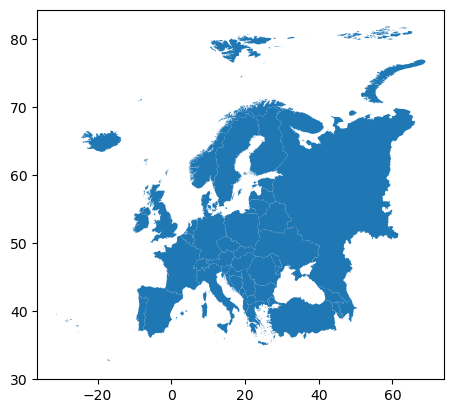

In [6]:
europe_shp = gpd.read_file('../data/geodata/shapefiles/europe/Europe.shp')
europe_shp.plot()
europe_shp.to_file("../data/geodata/geojson/europe.geojson", driver="GeoJSON")

In [10]:
gdf = gpd.read_file("../data/geodata/geojson/europe.geojson")

In [8]:
m = leafmap.Map()
m.add_gdf(gdf, layer_name="New York boroughs", fill_colors=["red", "green", "blue"])
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [13]:
gdf = gdf[~gdf.NAME.isin(["Faeroe Islands (Denmark)","Faeroe Islands (Denmark)","Russia","Jan Mayen (Norway)","Svalbard (Norway)"])]

In [17]:
gdf.to_file("../data/geodata/geojson/europe_mod_EU_contest.geojson", driver="GeoJSON")

In [ ]:
import leafmap
import geopandas as gpd

data = "https://raw.githubusercontent.com/giswqs/leafmap/master/examples/data/countries.geojson"
gdf = gpd.read_file(data)

m = leafmap.Map()
m.add_labels(data, "NAME", font_size="12pt", font_color="blue", font_family="arial", font_weight="bold")
m.add_gdf(gdf=gdf)
m

In [6]:
m = leafmap.Map(center=[40, -100], zoom=4)
cities = 'https://raw.githubusercontent.com/giswqs/leafmap/master/examples/data/us_cities.csv'
regions = 'https://raw.githubusercontent.com/giswqs/leafmap/master/examples/data/us_regions.geojson'

m.add_geojson(regions, layer_name='US Regions')
# m.add_points_from_xy(
#     cities,
#     x="longitude",
#     y="latitude",
#     color_column='region',
#     icon_names=['gear', 'map', 'leaf', 'globe'],
#     spin=True,
#     add_legend=True,
# )
m

Map(center=[40, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

<AxesSubplot:>

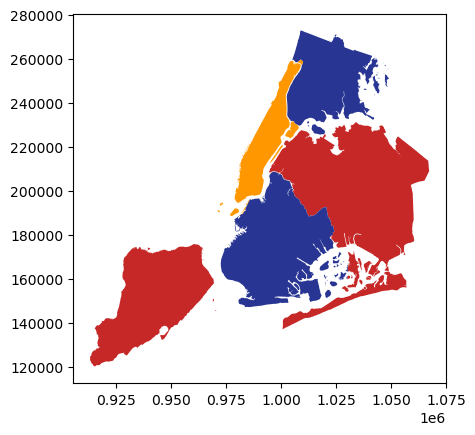

In [3]:
gdf = gpd.read_file(gpd.datasets.get_path('nybb'))
# adding a column with color names (gdf has 5 rows)
gdf['color'] = ['#C62828', '#C62828', '#283593', '#FF9800', '#283593']
gdf.plot(color=gdf['color'])  

In [49]:
gdf = gpd.read_file("../data/geodata/geojson/chf.geojson")

In [50]:
gdf

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,223,CHE,Switzerland,1,Aargau,Canton|Kanton|Chantun,Canton,None,Argovia|Arg¢via|Argovie,"POLYGON ((8.22503 47.61147, 8.22661 47.61130, ..."
1,223,CHE,Switzerland,2,Appenzell Ausserrhoden,Canton|Kanton|Chantun,Canton,None,Appenzell Ausser-Rhoden|Appenzell Outer Rhodes...,"POLYGON ((9.54239 47.47059, 9.54387 47.47031, ..."
2,223,CHE,Switzerland,3,Appenzell Innerrhoden,Canton|Kanton|Chantun,Canton,None,Appenzell Inner-Rhoden|Appenzell Inner Rhodes|...,"MULTIPOLYGON (((9.37930 47.38512, 9.37944 47.3..."
3,223,CHE,Switzerland,4,Basel,Canton|Kanton|Chantun,Canton,None,Bâle-Campagne|Basel-Country|Baselland|Basel-La...,"MULTIPOLYGON (((7.38339 47.41924, 7.38057 47.4..."
4,223,CHE,Switzerland,5,Basel,Canton|Kanton|Chantun,Canton,None,Bâle-Ville|Basel-City|Basel-Town|Basilea-Citad...,"POLYGON ((7.67336 47.58182, 7.67500 47.57977, ..."
5,223,CHE,Switzerland,6,Bern,Canton|Kanton|Chantun,Canton,None,Berna|Berne,"MULTIPOLYGON (((7.09284 46.89419, 7.09202 46.8..."
6,223,CHE,Switzerland,7,Fribourg,Canton|Kanton|Chantun,Canton,None,Freiburg|Friburg|Friburgo,"MULTIPOLYGON (((6.78581 46.74974, 6.78684 46.7..."
7,223,CHE,Switzerland,8,Genève,Canton|Kanton|Chantun,Canton,None,Cenevre|Genebra|Geneve|Geneva|Genevra|Genf|Gin...,"MULTIPOLYGON (((6.18406 46.34775, 6.18559 46.3..."
8,223,CHE,Switzerland,9,Glarus,Canton|Kanton|Chantun,Canton,None,Glaris|Glarona|Glaruna,"POLYGON ((9.07083 47.13050, 9.07307 47.12995, ..."
9,223,CHE,Switzerland,10,Graubünden,Canton|Kanton|Chantun,Canton,None,Graubünden|Grigioni|Grischun|Grisons,"MULTIPOLYGON (((10.20978 46.62572, 10.21465 46..."


In [12]:
if canton_select=="all Cantons":
    m = leafmap.Map(center=[46.449212, 7.734375], zoom=7)
    m.add_gdf(gdf, layer_name="Swiss Cantons", fill_colors=["red"])
    m.to_streamlit()

geopandas.geodataframe.GeoDataFrame

In [13]:
regions

'https://raw.githubusercontent.com/giswqs/leafmap/master/examples/data/us_regions.geojson'

In [3]:
path_to_data = gpd.datasets.get_path("nybb")
gdf = gpd.read_file(path_to_data)
gdf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [4]:
m = leafmap.Map()
m.add_gdf(gdf, layer_name="New York boroughs", fill_colors=["blue"])
m.add_gdf(gdf[gdf.BoroName=="Queens"], layer_name="choosen Canton", fill_colors=["red"])
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…